In [204]:
import numpy as np
import scipy as scipy
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt
from kneed import KneeLocator 

In [205]:
np.random.seed(42)

def generate_rand_system(m,n, cond, noise_std = 0):
    #diag_vals = ((np.random.randn(n)*10).round() + 1)**cond
    #diag_matrix = np.diag(diag_vals)

    M = np.random.randn(n, n)
    Q1,_ = np.linalg.qr(M)
    M = np.random.randn(n, n)
    Q2,_ = np.linalg.qr(M)
    U = Q1 @ np.diag(1 / np.arange(1,n+1)**cond) @ Q2.T

    A = np.random.randn(m,n) @ U
    x_true = np.random.randn(n,1)
    b_clean = A @ x_true
    noise = noise_std * np.random.randn(m, 1)
    b = b_clean + noise
    x_star = np.linalg.lstsq(A,b)[0] #even though b = Ax, block Kaczmarz projects onto minimum norm solution of Ax = b, i.e. x_star.
    return A, b, x_true, x_star

In [206]:
def optimal_s_lambda(A, C, k):
    """
    Find optimal values of lambda and block size
    """
    m = np.shape(A)[0]
    u, s, vt = np.linalg.svd(A)
    tail = s[k:]
    k_bar_k = (np.linalg.norm(A, ord = "fro") / np.min(tail)) / np.sqrt(len(tail))   #normalized tail condition number
    
    optimal_s = np.ceil(C * k * np.log(m * k_bar_k)) # optimal block size
    optimal_lambda = (np.sum(tail ** 2))/k
    return optimal_s, optimal_lambda

In [207]:
def calculate_lamda_mu_nu(A, k):
    """
    Estimate lambda, mu, and nu from A^T A.
    k is block size
    """
    s2 = np.linalg.eigvalsh(A)
    s2[s2 < np.mean(s2) * 1e-8] = 0

    def f(lamda):
        return np.sum(s2 / (s2 + lamda)) - k

    lamda = root_scalar(f, bracket=[1e-8, np.max(s2) * len(s2) * 1e8]).root
    s2_min = np.min(s2[s2 > 0])
    mu = s2_min / (s2_min + lamda)
    num = np.sum((s2 > 0) / (s2 + lamda))
    denom = np.sum(s2 / (s2 + lamda)**2)
    lamda_prime = lamda * num / denom
    nu = 1 + lamda_prime / (s2_min + lamda)

    return lamda, mu, nu

In [208]:
def update_rho_adaptive(residuals, ti, i, p, r_hat_prev, alpha_prev):
    """
    Adaptive rho update based on averaged residual norm squared ratios.
    """
    #eps_t = np.linalg.norm(residuals[ti])**2
    #eps_tp = np.linalg.norm(residuals[ti - p])**2 #np.mean([r**2 for r in residuals[-2*p:-p]])
    eps_t = np.sum(np.array(residuals[ti-p:ti])**2)
    eps_tp = np.sum(np.array(residuals[ti-2*p:ti-p])**2)
    r_ip = eps_t / eps_tp

    a_new = (i + 1) ** np.log(i + 1)
    a_old = (i) ** np.log(i)
    alpha = a_old/a_new
    #alpha = (alpha_prev) / a_ti

    r_hat = alpha * r_hat_prev + (1 - alpha) * min(1, r_ip)
    rho_new = max(0, 1 - r_hat ** (1 / p))
    #rho_new = max(min(rho_new, 1), 0.0)  # clamp rho to [0, 1] to avoid negative rhos, causing divergence

    return rho_new, r_hat, alpha

In [238]:
def kaczmarz(A, b, lamb, accelerated, eta, rho, n_steps, block_size, p, x_true = None):
    m, n = A.shape
    x = np.zeros((n,1))
    residuals = []
    residual_norms = []
    update_norms = []
    errors = []
    rhos = []
    
    mtm = 0
    #mtm_param = 1.0 if accelerated else 0.0
    if accelerated:
        mtm_param = (1 - rho)/(1 + rho)
    else:
        mtm_param = 0
        
    r_hat = 1
    checkpoint_idx = 1
    #nu = 2*n/block_size
    #eta = 1/nu # start eta at 0, doesn't change until first momentum update --> causes massive spike 
    #eta = 0
    
    b_norm = np.linalg.norm(b)
    
    for t in range(n_steps):
        tau = np.random.choice(m, block_size, replace=False)
        A_tau = A[tau, :]
        b_tau = b[tau]
    
        #regularized projection: 
        cho = scipy.linalg.cho_factor(A_tau @ A_tau.T + lamb * np.eye(block_size))
        w = A_tau.T @ scipy.linalg.cho_solve(cho, (A_tau @ x - b_tau)) 
        mtm = mtm_param * (mtm - w)
        x = x - w + eta * mtm

        #storing residual, which should be getting smaller
        system = A @ x - b
        residuals.append(np.linalg.norm(system))
        residual_norms.append(np.linalg.norm(system) / b_norm)

        #storing error
        if x_true is not None:
            errors.append(np.linalg.norm(x - x_true))

        if t % p == 0 and t >= 2 * p and accelerated:
            #rho, r_hat, alpha = update_rho_adaptive(residuals, t, checkpoint_idx, p, r_hat, alpha)
            eps_t = np.sum(np.array(residuals[t-p:t])**2)
            eps_tp = np.sum(np.array(residuals[t-2*p:t-p])**2)
            r_ip = eps_t / eps_tp

            a_new = (checkpoint_idx + 1) ** np.log(checkpoint_idx + 1)
            a_old = (checkpoint_idx) ** np.log(checkpoint_idx)
            alpha = a_old/a_new
        
            r_hat = alpha * r_hat + (1 - alpha) * min(1, r_ip)
            rho = max(0, 1 - r_hat ** (1 / p))
            mtm_param = (1-rho)/(1+rho)
            #eta = 1/nu
            checkpoint_idx += 1
        
        rhos.append(rho)

    return x, residuals, residual_norms, update_norms, errors, rhos

In [137]:
def verify(A, b, l, r, e, bl_s, x_true):
     #Run Kaczmarz
    x_kacz, residuals, residual_norms, update_norms, errors, rhos = kaczmarz(A, b, lamb = l, rho = r, eta = e, n_steps = 10, block_size = bl_s, p = 10, x_true = x_true)

    #Plot metrics
    fig, axs = plt.subplots(3, 1, figsize=(10, 10))

    axs[0].plot(residuals)
    axs[0].set_title("1. Residual Norm ||Ax - b|| (inconsistent system)")
    axs[0].set_xlabel("Iteration")
    axs[0].set_ylabel("Residual")

    axs[1].plot(update_norms)
    axs[1].set_title("2. Update Norm ||x_{t+1} - x_t||")
    axs[1].set_xlabel("Iteration")
    axs[1].set_ylabel("Update Size")

    axs[2].plot(errors)
    axs[2].set_title("3. Error Norm ||x - x_true||")
    axs[2].set_xlabel("Iteration")
    axs[2].set_ylabel("Error")

    plt.tight_layout()
    plt.show()


In [138]:
def k_singular_values(A):
    u, sing, vt = np.linalg.svd(A)
    knee = KneeLocator(range(len(sing)), sing, curve='convex', direction='decreasing')
    return knee.knee + 1
    # second_diff = np.diff(sing, n=2)
    # elbow_index = np.argmax(second_diff) + 1 
    # #num_outliers = elbow_index + 1
    # return elbow_index

/tmp/ipykernel_13973/4066594780.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x_star = np.linalg.lstsq(A,b)[0] #even though b = Ax, block Kaczmarz projects onto minimum norm solution of Ax = b, i.e. x_star.


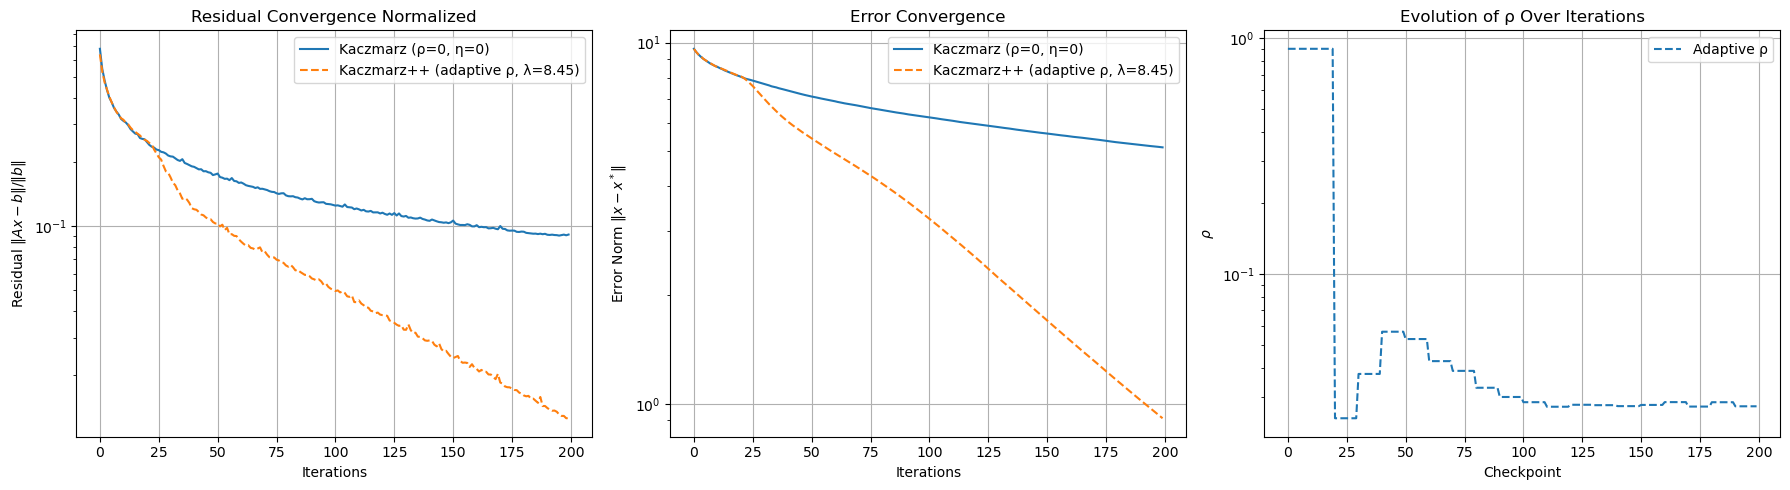

block size: 97


In [239]:
np.random.seed(42)

m = 1000
n = 100

A, b, x_true, x_star = generate_rand_system(m, n, 1, noise_std = 0)
k = k_singular_values(A)

#block size, lambda
s = optimal_s_lambda(A, 1, k)[0].astype(int)
lamb = optimal_s_lambda(A, 1, k)[1]
#lamb = calculate_lamda_mu_nu(A.T @ A, s)[0]
#eta = s/(2*calculate_lamda_mu_nu(A.T @ A, s)[2])
#lamb = 0.001
eta = s/(2*n)

#no adaptive acceleration
x_kacz_reg, residuals_reg, residual_norms_reg, update_norms_reg, errors_reg, rhos_reg = kaczmarz(A, b, lamb = lamb, accelerated = False, eta = 0, rho = 0, n_steps = 200, block_size = s, p = 10, x_true = x_star)
#adaptive acceleration
x_kacz_aa, residuals_reg_aa, residual_norms_aa, update_norms_reg_aa, errors_reg_aa, rhos_aa = kaczmarz(A, b, lamb = lamb, accelerated = True, eta = eta, rho = 0.9, n_steps = 200, block_size = s, p = 10, x_true = x_star)


fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Residual
axs[0].plot(residual_norms_reg, label="Kaczmarz (ρ=0, η=0)")
axs[0].plot(residual_norms_aa, label=f"Kaczmarz++ (adaptive ρ, λ={lamb:.3g})", linestyle='--')
axs[0].set_yscale("log")
axs[0].set_title("Residual Convergence Normalized")
axs[0].set_xlabel("Iterations")
axs[0].set_ylabel(r"Residual $\|Ax - b\| / \|b\|$")
axs[0].legend()
axs[0].grid(True)

# Error
axs[1].plot(errors_reg, label="Kaczmarz (ρ=0, η=0)")
axs[1].plot(errors_reg_aa, label=f"Kaczmarz++ (adaptive ρ, λ={lamb:.3g})", linestyle='--')
axs[1].set_yscale("log")
axs[1].set_title("Error Convergence")
axs[1].set_xlabel("Iterations")
axs[1].set_ylabel(r"Error Norm $\|x - x^*\|$")
axs[1].legend()
axs[1].grid(True)

# Adaptive ρ
axs[2].plot(rhos_aa, label="Adaptive ρ", linestyle='--')
axs[2].set_yscale("log")
axs[2].set_title("Evolution of ρ Over Iterations")
axs[2].set_xlabel("Checkpoint")
axs[2].set_ylabel(r"$\rho$")
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

print(f"block size: {s}")

In [214]:
p_values = [1, 5, 10, 20, 50, 100]
results = {}

for p in p_values:
    x_out, residuals, residual_norms, update_norms, errors, rhos = kaczmarz(
        A, b, lamb=lamb, rho=0.9, eta=eta,
        n_steps=200, block_size=s, x_true=x_true, p=p
    )
    results[p] = {
        'residuals': residuals,
        'errors': errors,
        'rhos': rhos
    }

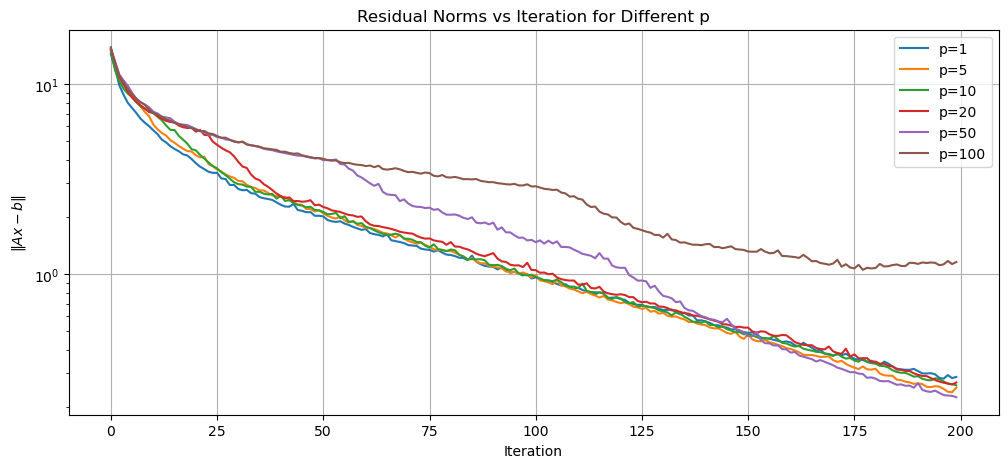

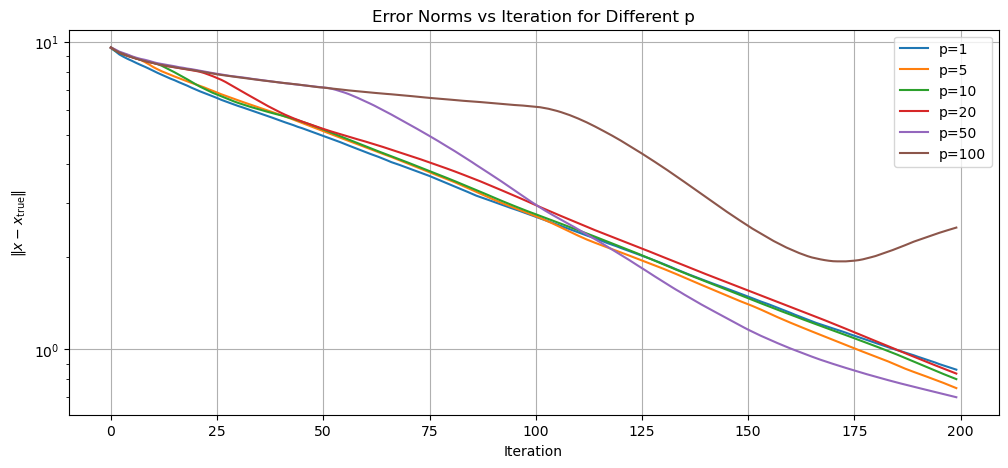

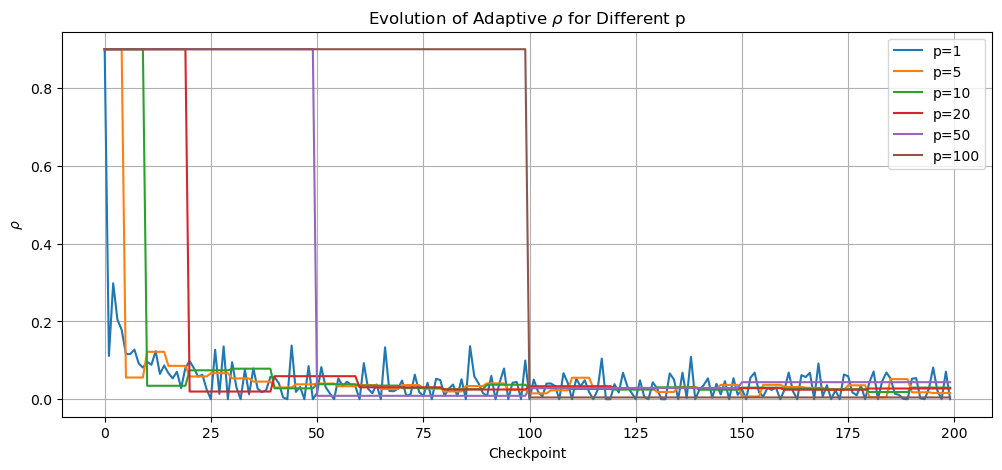

In [215]:
# Residuals plot
plt.figure(figsize=(12, 5))
for p in p_values:
    plt.plot(results[p]['residuals'], label=f"p={p}")
plt.yscale("log")
plt.title("Residual Norms vs Iteration for Different p")
plt.xlabel("Iteration")
plt.ylabel(r"$\|Ax - b\|$")
plt.legend()
plt.grid(True)
plt.show()

# Error plot
plt.figure(figsize=(12, 5))
for p in p_values:
    if results[p]['errors']:  # check if not None
        plt.plot(results[p]['errors'], label=f"p={p}")
plt.yscale("log")
plt.title("Error Norms vs Iteration for Different p")
plt.xlabel("Iteration")
plt.ylabel(r"$\|x - x_{\mathrm{true}}\|$")
plt.legend()
plt.grid(True)
plt.show()

# Rho plot
plt.figure(figsize=(12, 5))
for p in p_values:
    plt.plot(results[p]['rhos'], label=f"p={p}")
plt.title("Evolution of Adaptive $\\rho$ for Different p")
plt.xlabel("Checkpoint")
plt.ylabel(r"$\rho$")
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_13973/4066594780.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x_star = np.linalg.lstsq(A,b)[0] #even though b = Ax, block Kaczmarz projects onto minimum norm solution of Ax = b, i.e. x_star.


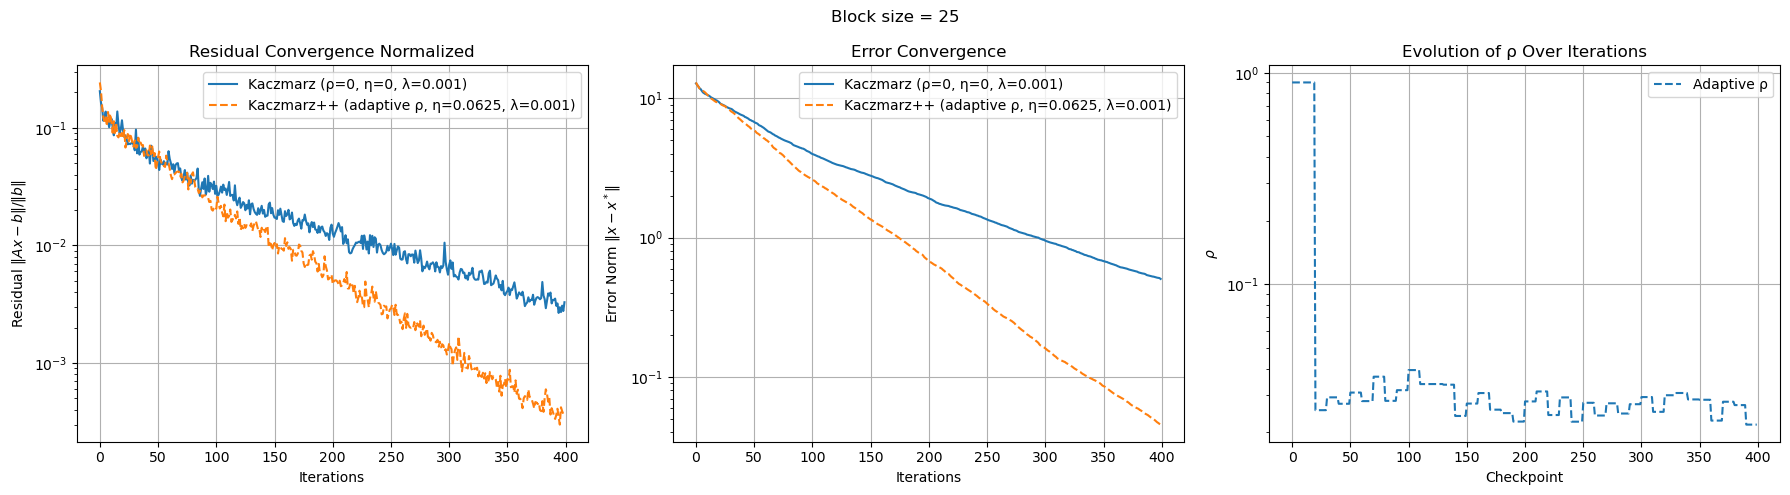

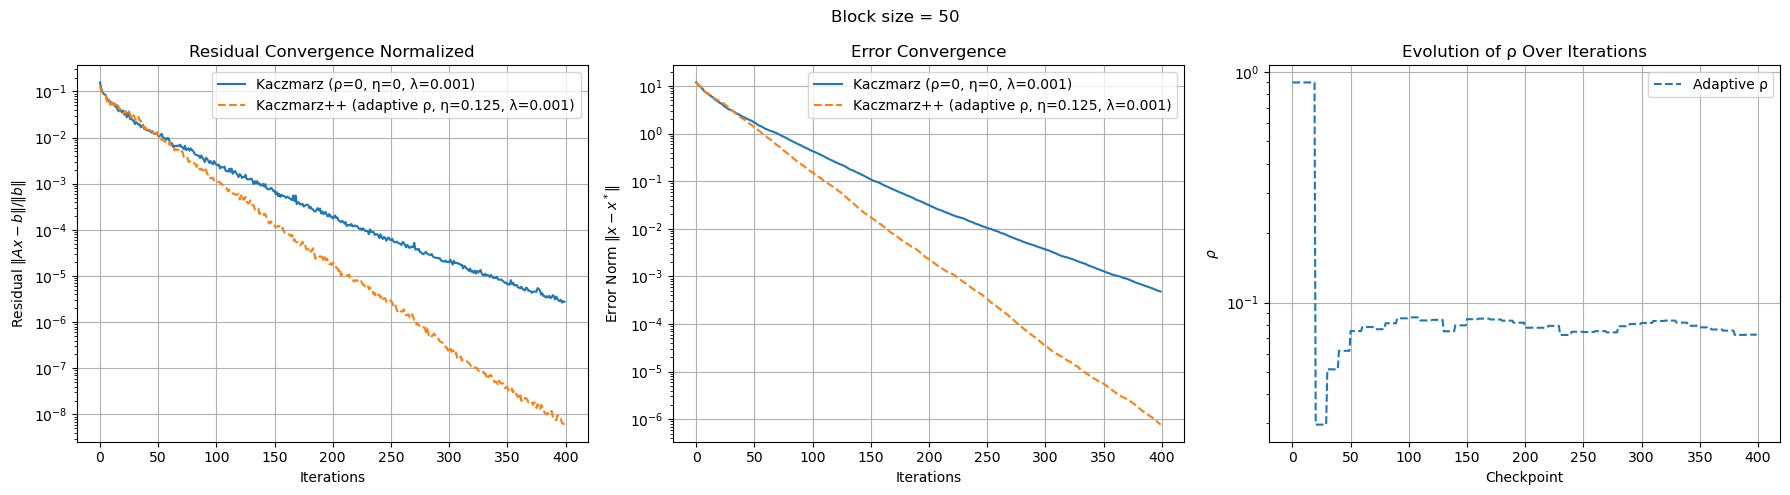

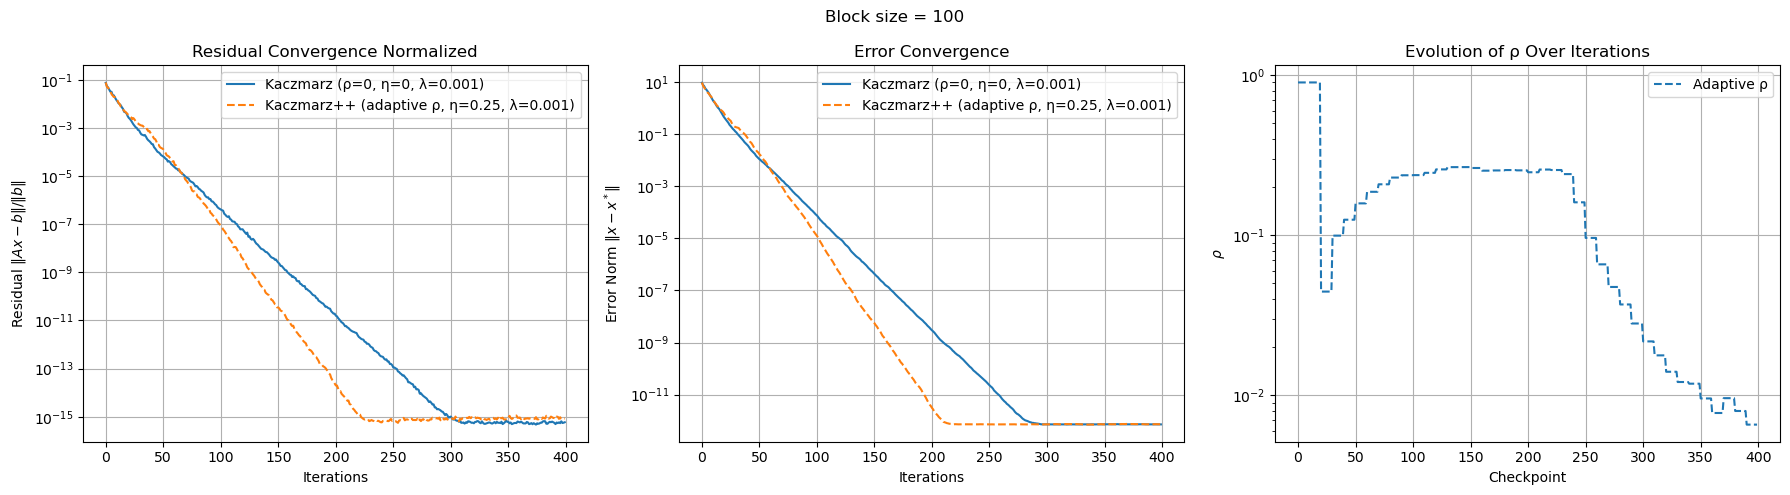

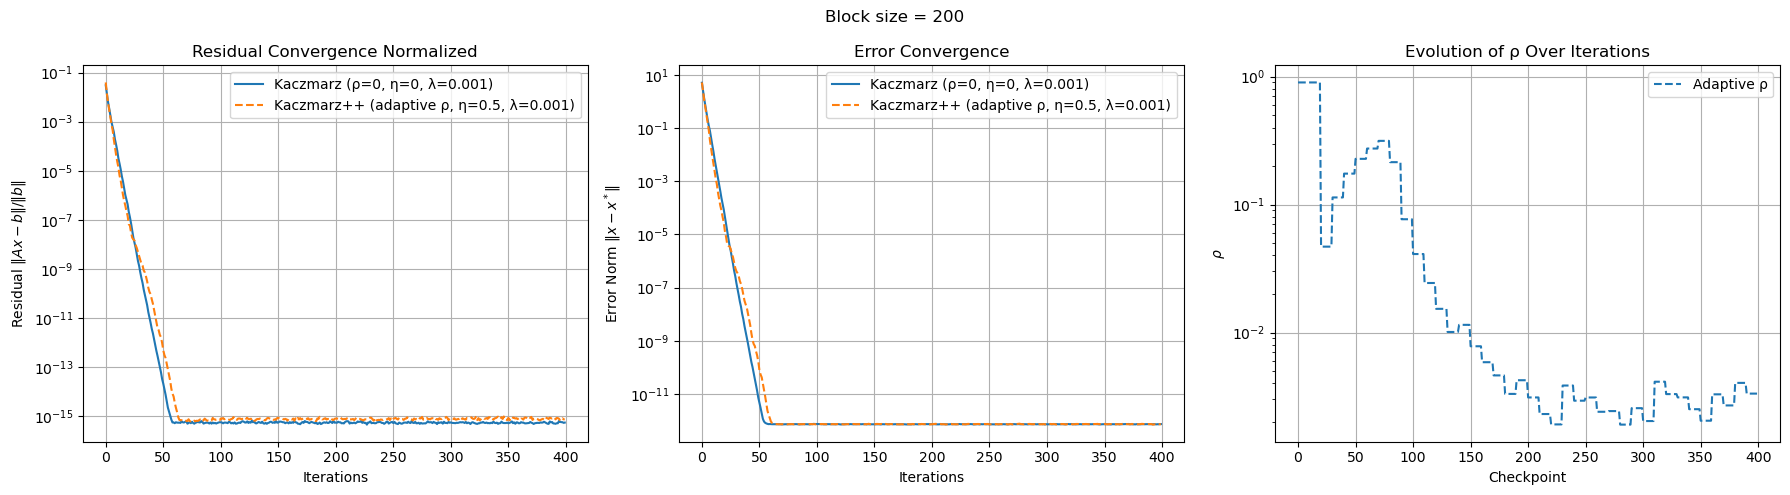

In [241]:
np.random.seed(42)

potential_block_sizes = np.array([25, 50, 100, 200])

m = 1000
n = 200
A, b, x_true, x_star = generate_rand_system(m, n, 1, noise_std = 0)
k = k_singular_values(A)

#block size, lambda
#s = optimal_s_lambda(A, 1, k)[0].astype(int)
#lamb = optimal_s_lambda(A, 1, k)[1]
lamb_reg = 0.001

for size in potential_block_sizes:
    eta = size/(2*n)
    #lamb_aa = calculate_lamda_mu_nu(A.T @ A, size)[0]
    #lamb_aa = optimal_s_lambda(A, 1, k)[1]
    lamb_aa = 0.001
    #no adaptive acceleration
    x_kacz_reg, residuals_reg, residual_norms_reg, update_norms_reg, errors_reg, rhos_reg = kaczmarz(A, b, lamb = lamb_reg, accelerated = False, rho = 0, eta = 0, n_steps = 400, block_size = size, p = 10, x_true = x_star)
    #adaptive acceleration
    x_kacz_aa, residuals_reg_aa, residual_norms_aa, update_norms_reg_aa, errors_reg_aa, rhos_aa = kaczmarz(A, b, lamb = lamb_aa, accelerated = True, rho = 0.9, eta = eta, n_steps = 400, block_size = size, p = 10, x_true = x_star)


    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"Block size = {size}")

    # Residual
    axs[0].plot(residual_norms_reg, label=f"Kaczmarz (ρ=0, η=0, λ={lamb_reg:.3g})")
    axs[0].plot(residual_norms_aa, label=f"Kaczmarz++ (adaptive ρ, η={eta:.3g}, λ={lamb_aa:.3g})", linestyle='--')
    axs[0].set_yscale("log")
    axs[0].set_title("Residual Convergence Normalized")
    axs[0].set_xlabel("Iterations")
    axs[0].set_ylabel(r"Residual $\|Ax - b\| / \|b\|$")
    axs[0].legend()
    axs[0].grid(True)
    
    # Error
    axs[1].plot(errors_reg, label=f"Kaczmarz (ρ=0, η=0, λ={lamb_reg:.3g})")
    axs[1].plot(errors_reg_aa, label=f"Kaczmarz++ (adaptive ρ, η={eta:.3g}, λ={lamb_aa:.3g})", linestyle='--')
    axs[1].set_yscale("log")
    axs[1].set_title("Error Convergence")
    axs[1].set_xlabel("Iterations")
    axs[1].set_ylabel(r"Error Norm $\|x - x^*\|$")
    axs[1].legend()
    axs[1].grid(True)
    
    # Adaptive ρ
    axs[2].plot(rhos_aa, label="Adaptive ρ", linestyle='--')
    axs[2].set_yscale("log")
    axs[2].set_title("Evolution of ρ Over Iterations")
    axs[2].set_xlabel("Checkpoint")
    axs[2].set_ylabel(r"$\rho$")
    axs[2].legend()
    axs[2].grid(True)
    
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_13973/4066594780.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x_star = np.linalg.lstsq(A,b)[0] #even though b = Ax, block Kaczmarz projects onto minimum norm solution of Ax = b, i.e. x_star.


block size: 74


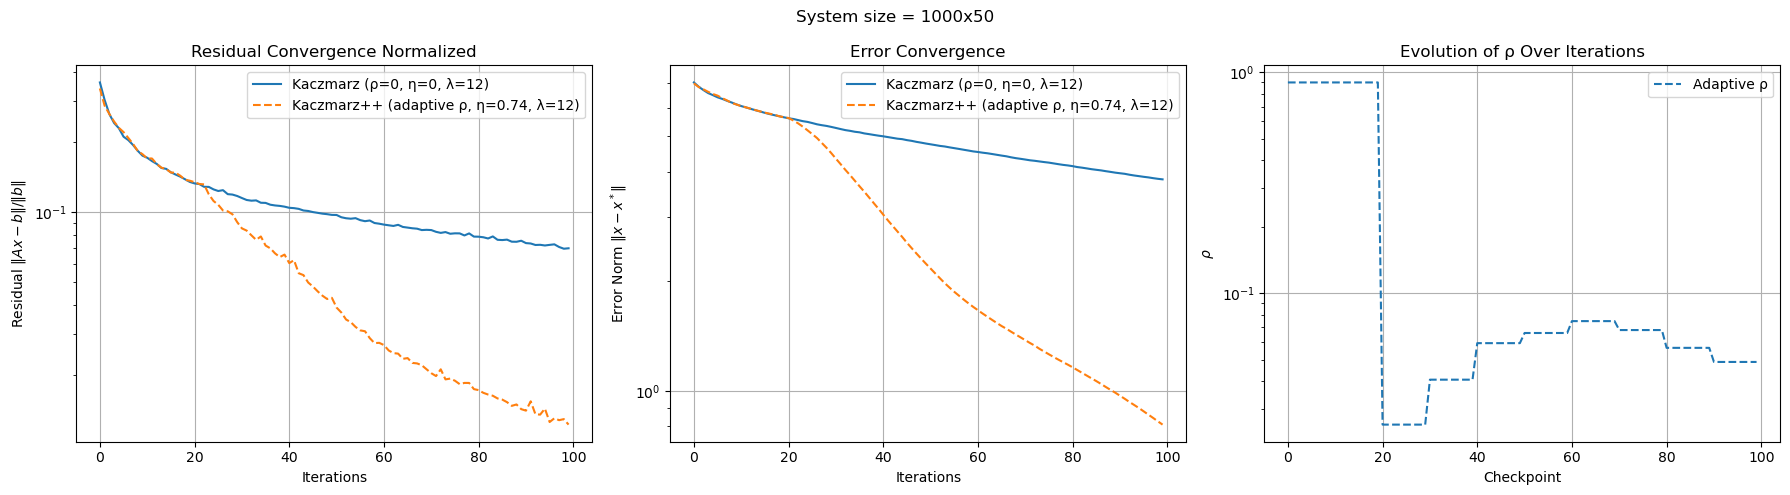

block size: 97


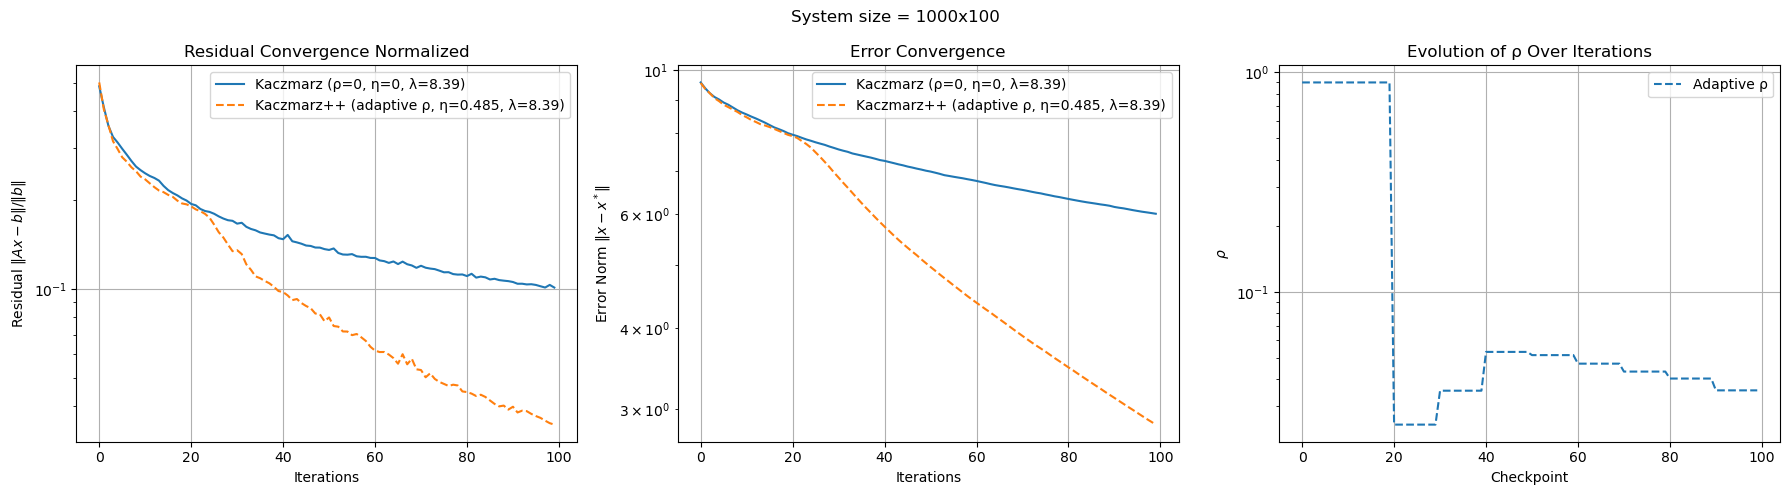

block size: 140


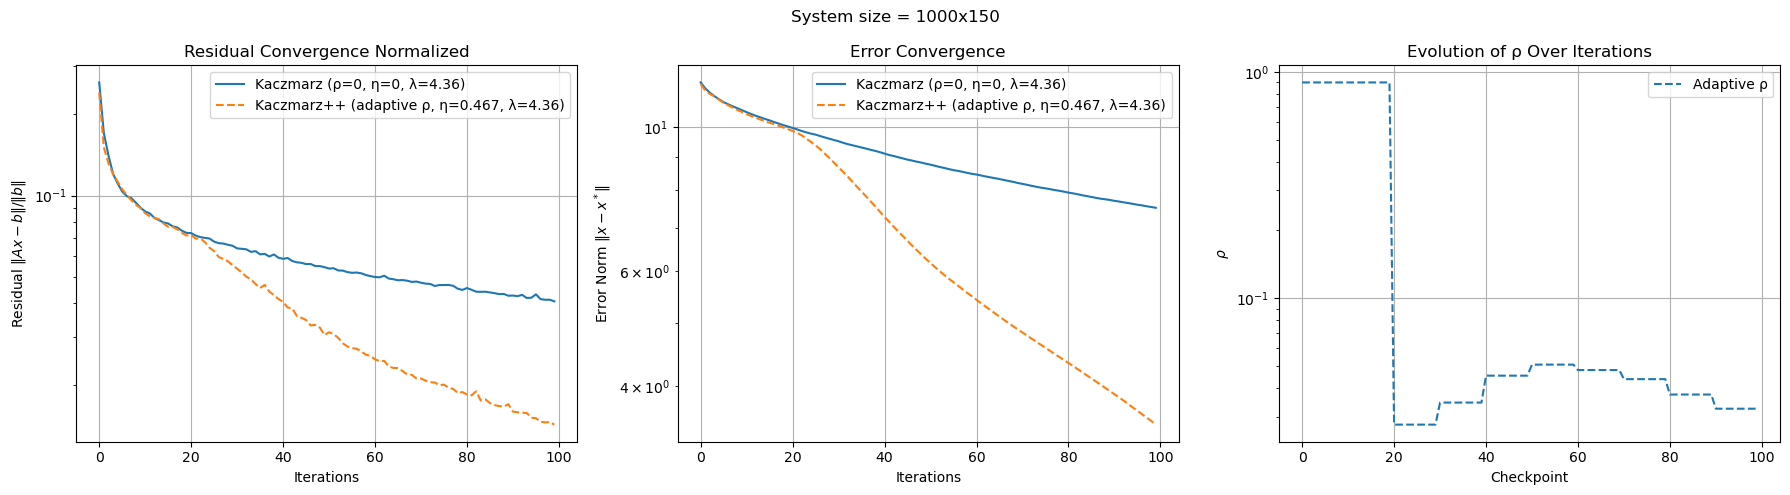

block size: 182


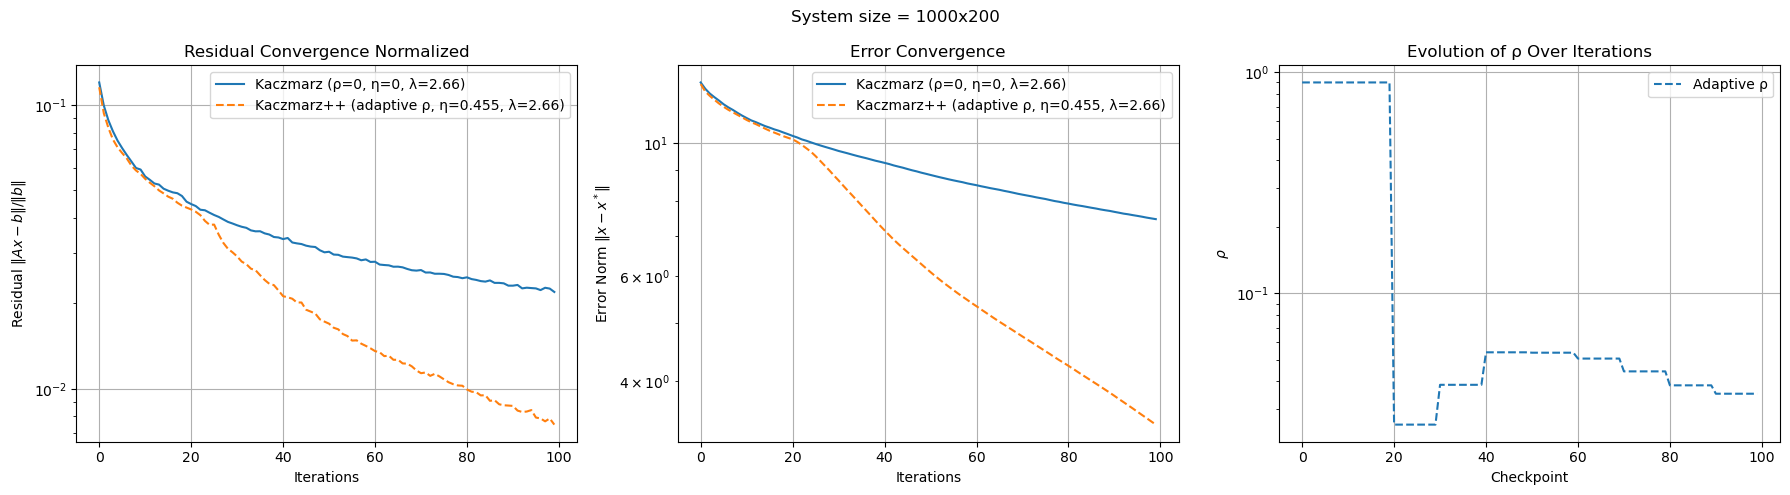

In [244]:
np.random.seed(42)

potential_n_values = np.array([50, 100, 150, 200])

m = 1000
for pot_n in potential_n_values:
    A, b, x_true, x_star = generate_rand_system(m, pot_n, cond=1)
    k = k_singular_values(A)
    s = optimal_s_lambda(A, 1, k)[0].astype(int)
    print(f"block size: {s}")
    lamb = optimal_s_lambda(A, 1, k)[1]
    #lamb = calculate_lamda_mu_nu(A.T @ A, s)[0]
    #lamb = 0.001
    
    eta = s/(2*pot_n)
    #no adaptive acceleration
    x_kacz_reg, residuals_reg, residual_norms_reg, update_norms_reg, errors_reg, rhos_reg = kaczmarz(A, b, lamb = lamb, accelerated = False, rho = 0, eta = 0, n_steps = 100, block_size = s, p = 10, x_true = x_star)
    #adaptive acceleration
    x_kacz_aa, residuals_reg_aa, residual_norms_aa, update_norms_reg_aa, errors_reg_aa, rhos_aa = kaczmarz(A, b, lamb = lamb, accelerated = True, rho = 0.9, eta = eta, n_steps = 100, block_size = s, p = 10, x_true = x_star)

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"System size = 1000x{pot_n}")

    # Residual
    axs[0].plot(residual_norms_reg, label=f"Kaczmarz (ρ=0, η=0, λ={lamb:.3g})")
    axs[0].plot(residual_norms_aa, label=f"Kaczmarz++ (adaptive ρ, η={eta:.3g}, λ={lamb:.3g})", linestyle='--')
    axs[0].set_yscale("log")
    axs[0].set_title("Residual Convergence Normalized")
    axs[0].set_xlabel("Iterations")
    axs[0].set_ylabel(r"Residual $\|Ax - b\| / \|b\|$")
    axs[0].legend()
    axs[0].grid(True)
    
    # Error
    axs[1].plot(errors_reg, label=f"Kaczmarz (ρ=0, η=0, λ={lamb:.3g})")
    axs[1].plot(errors_reg_aa, label=f"Kaczmarz++ (adaptive ρ, η={eta:.3g}, λ={lamb:.3g})", linestyle='--')
    axs[1].set_yscale("log")
    axs[1].set_title("Error Convergence")
    axs[1].set_xlabel("Iterations")
    axs[1].set_ylabel(r"Error Norm $\|x - x^*\|$")
    axs[1].legend()
    axs[1].grid(True)
    
    # Adaptive ρ
    axs[2].plot(rhos_aa, label="Adaptive ρ", linestyle='--')
    axs[2].set_yscale("log")
    axs[2].set_title("Evolution of ρ Over Iterations")
    axs[2].set_xlabel("Checkpoint")
    axs[2].set_ylabel(r"$\rho$")
    axs[2].legend()
    axs[2].grid(True)
    
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_13973/4066594780.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x_star = np.linalg.lstsq(A,b)[0] #even though b = Ax, block Kaczmarz projects onto minimum norm solution of Ax = b, i.e. x_star.


block size: 97


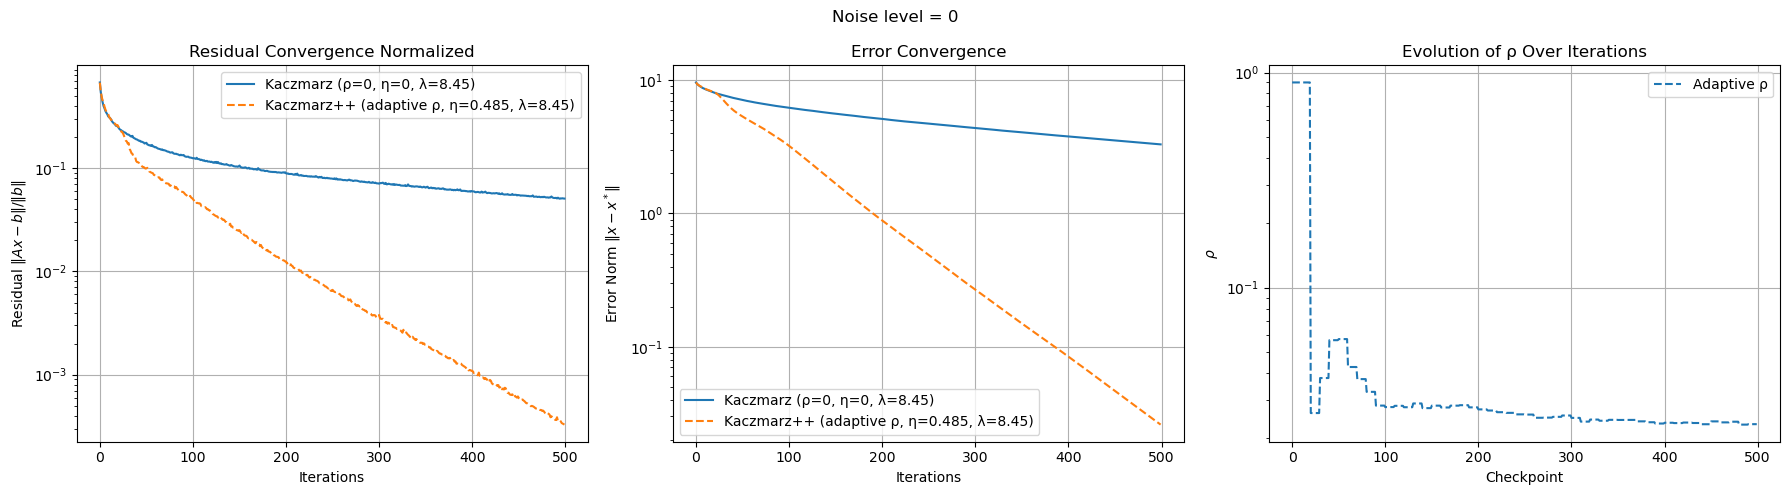

block size: 107


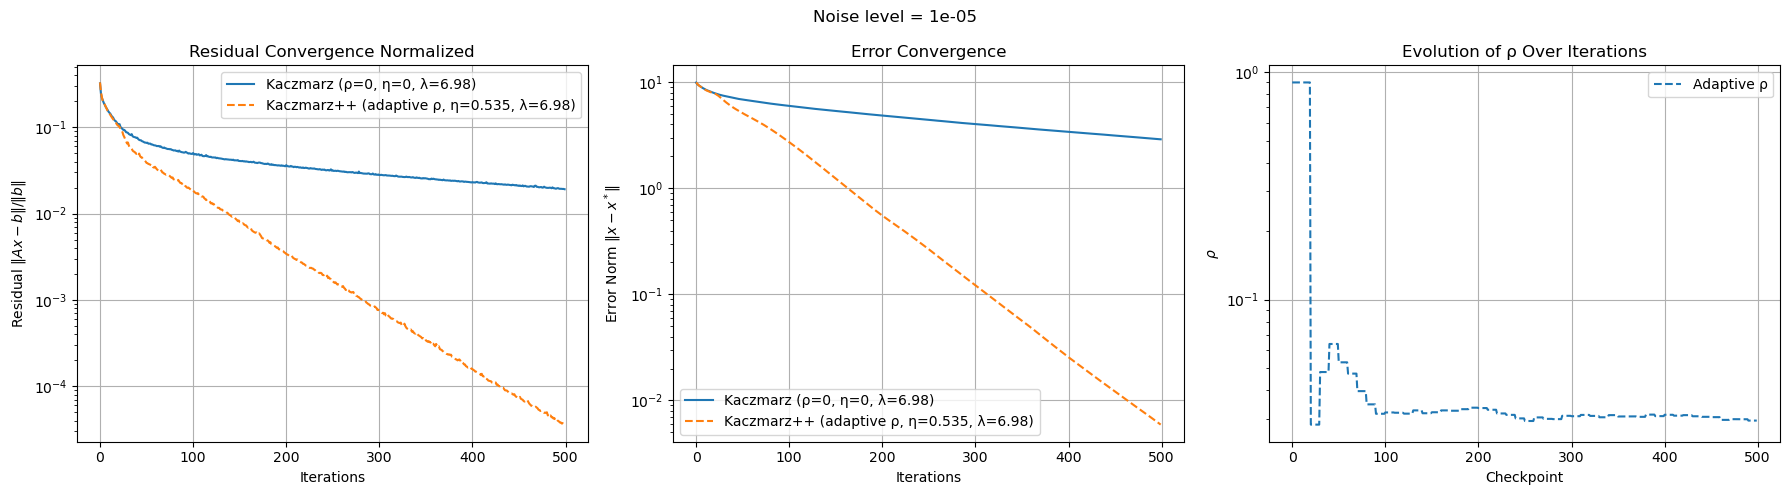

block size: 97


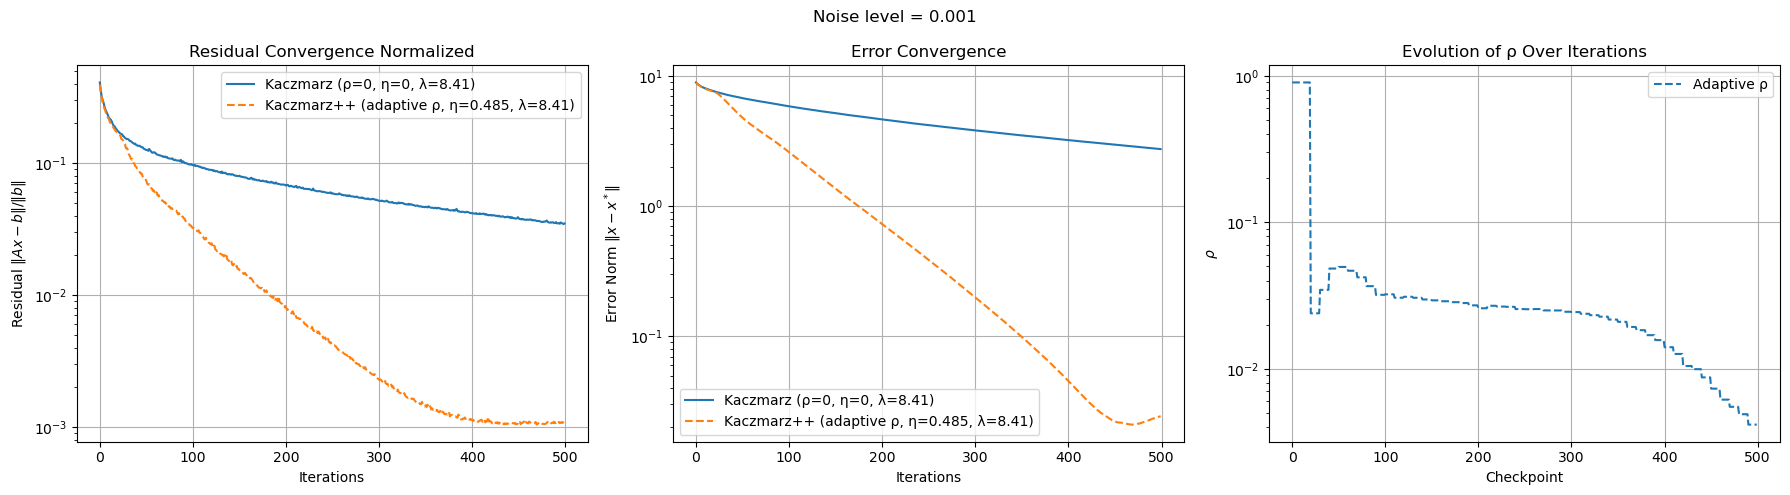

block size: 97


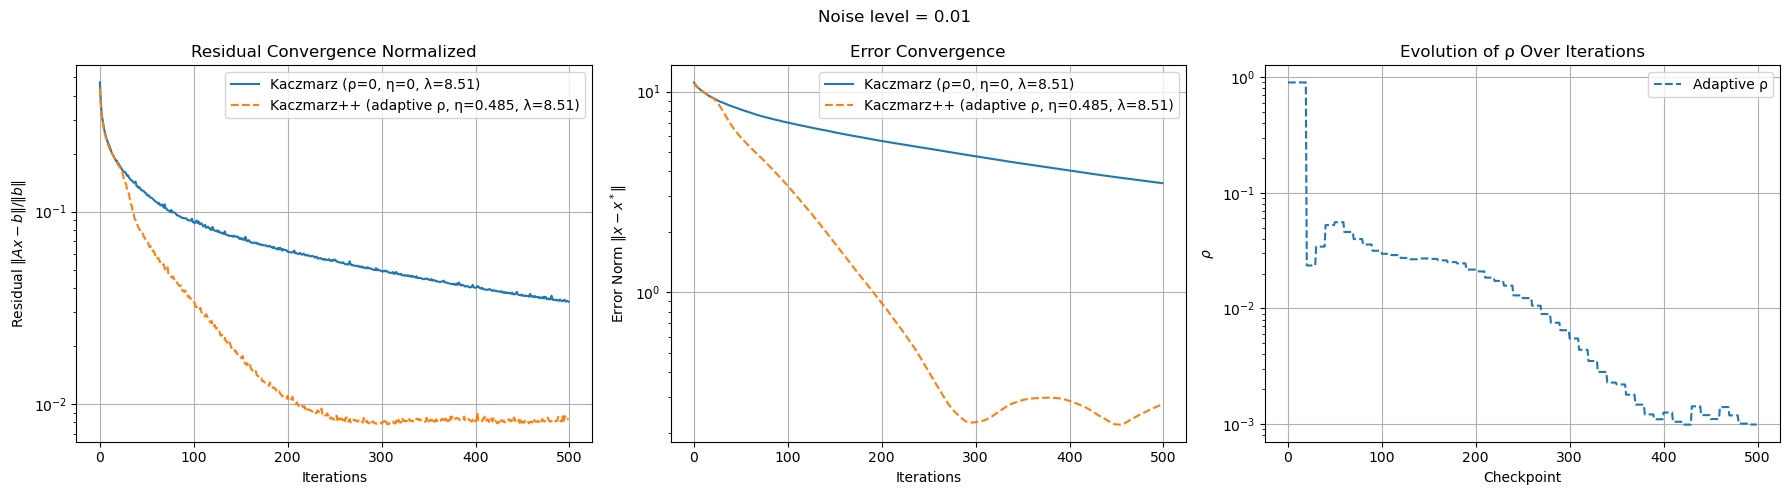

In [246]:
np.random.seed(42)

noise_levels = [0, 1e-5, 1e-3, 1e-2]

m = 1000
n = 100 

for noise in noise_levels:
    A, b, x_true, x_star = generate_rand_system(m,n, cond=1, noise_std = noise)
    k = k_singular_values(A)
    lamb = optimal_s_lambda(A, 1, k)[1]
    #lamb = 0.001
    s = optimal_s_lambda(A, 1, k)[0].astype(int)
    print(f"block size: {s}")
    eta = s/(2*n)
    #no adaptive acceleration
    x_kacz_reg, residuals_reg, residual_norms_reg, update_norms_reg, errors_reg, rhos_reg = kaczmarz(A, b, lamb = lamb, accelerated = False, rho = 0, eta = 0, n_steps = 500, block_size = s, p = 10, x_true = x_true)
    #adaptive acceleration
    x_kacz_aa, residuals_reg_aa, residual_norms_aa, update_norms_reg_aa, errors_reg_aa, rhos_aa = kaczmarz(A, b, lamb = lamb, accelerated = True, rho = 0.9, eta = eta, n_steps = 500, block_size = s, p = 10, x_true = x_true)

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"Noise level = {noise}")

    # Residual
    axs[0].plot(residual_norms_reg, label=f"Kaczmarz (ρ=0, η=0, λ={lamb:.3g})")
    axs[0].plot(residual_norms_aa, label=f"Kaczmarz++ (adaptive ρ, η={eta:.3g}, λ={lamb:.3g})", linestyle='--')
    axs[0].set_yscale("log")
    axs[0].set_title("Residual Convergence Normalized")
    axs[0].set_xlabel("Iterations")
    axs[0].set_ylabel(r"Residual $\|Ax - b\| / \|b\|$")
    axs[0].legend()
    axs[0].grid(True)
    
    # Error
    axs[1].plot(errors_reg, label=f"Kaczmarz (ρ=0, η=0, λ={lamb:.3g})")
    axs[1].plot(errors_reg_aa, label=f"Kaczmarz++ (adaptive ρ, η={eta:.3g}, λ={lamb:.3g})", linestyle='--')
    axs[1].set_yscale("log")
    axs[1].set_title("Error Convergence")
    axs[1].set_xlabel("Iterations")
    axs[1].set_ylabel(r"Error Norm $\|x - x^*\|$")
    axs[1].legend()
    axs[1].grid(True)
    
    # Adaptive ρ
    axs[2].plot(rhos_aa, label="Adaptive ρ", linestyle='--')
    axs[2].set_yscale("log")
    axs[2].set_title("Evolution of ρ Over Iterations")
    axs[2].set_xlabel("Checkpoint")
    axs[2].set_ylabel(r"$\rho$")
    axs[2].legend()
    axs[2].grid(True)
    
    plt.tight_layout()
    plt.show()
    

/tmp/ipykernel_13973/4066594780.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x_star = np.linalg.lstsq(A,b)[0] #even though b = Ax, block Kaczmarz projects onto minimum norm solution of Ax = b, i.e. x_star.


block size: 50


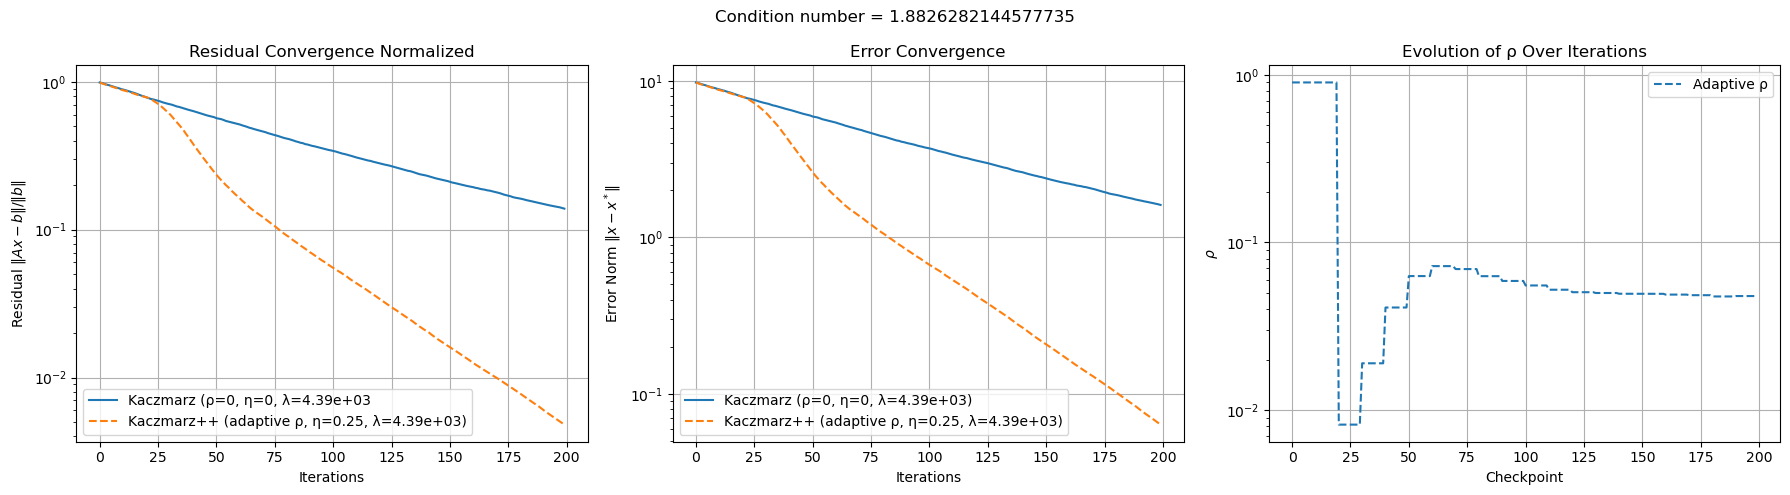

block size: 50


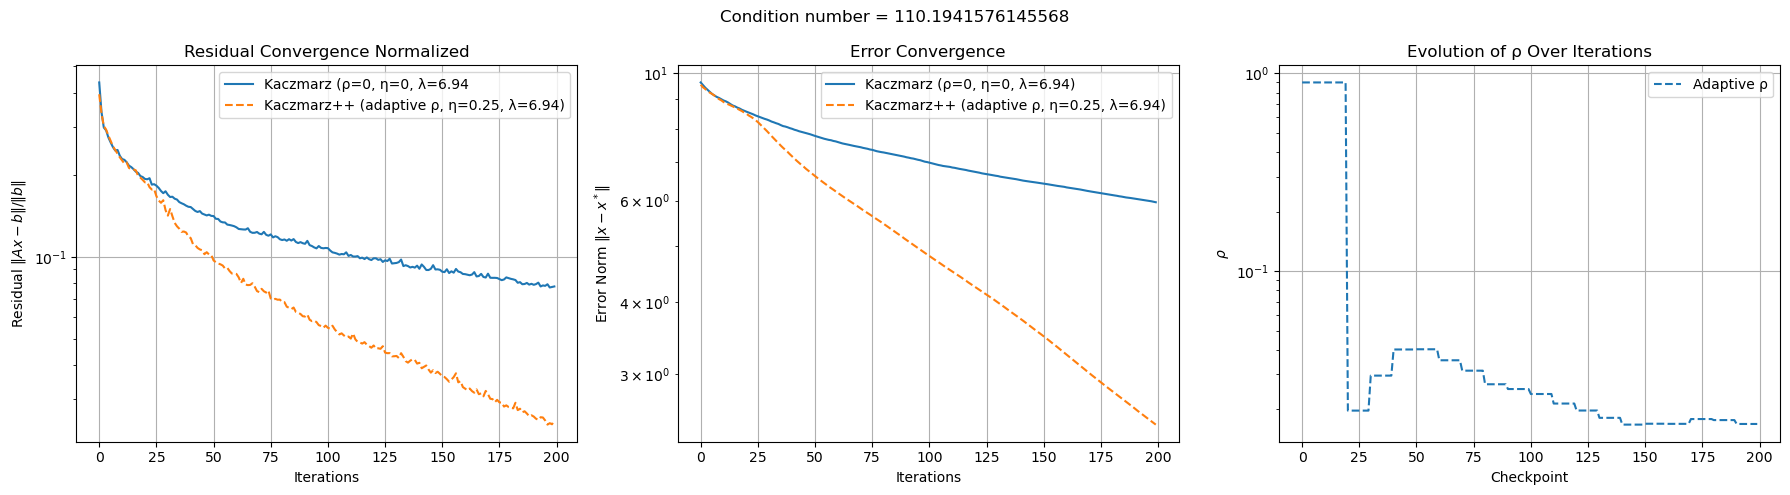

block size: 50


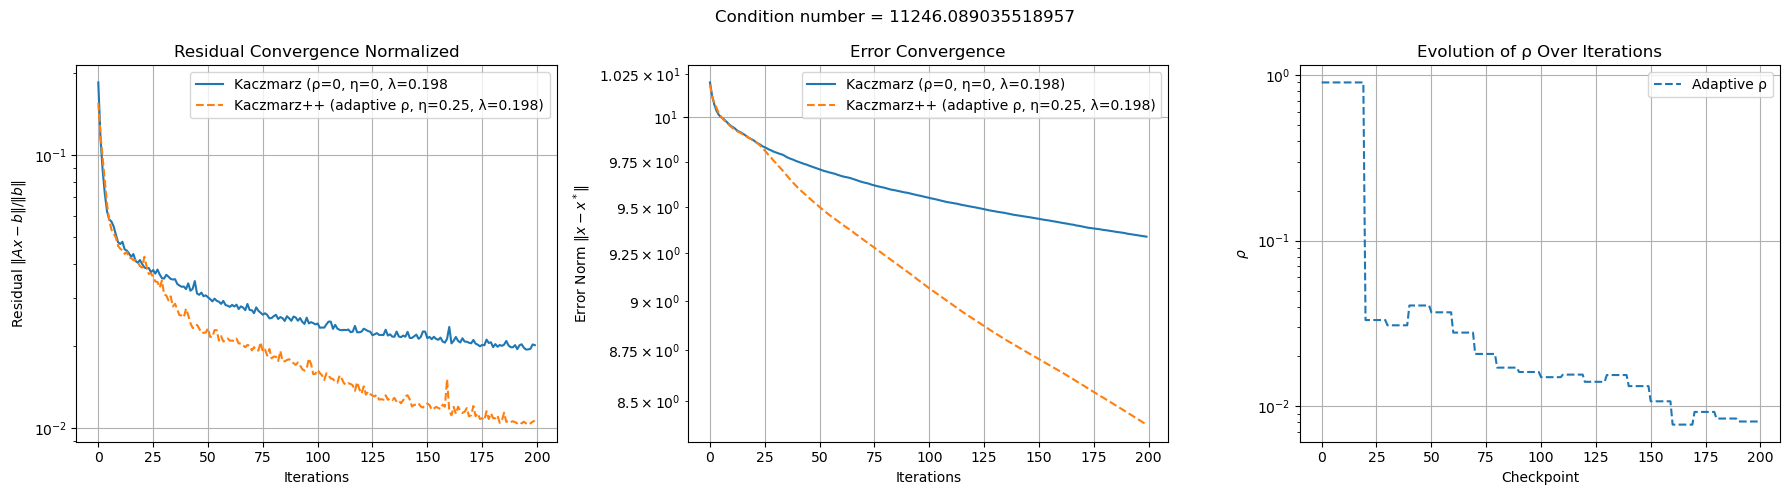

block size: 50


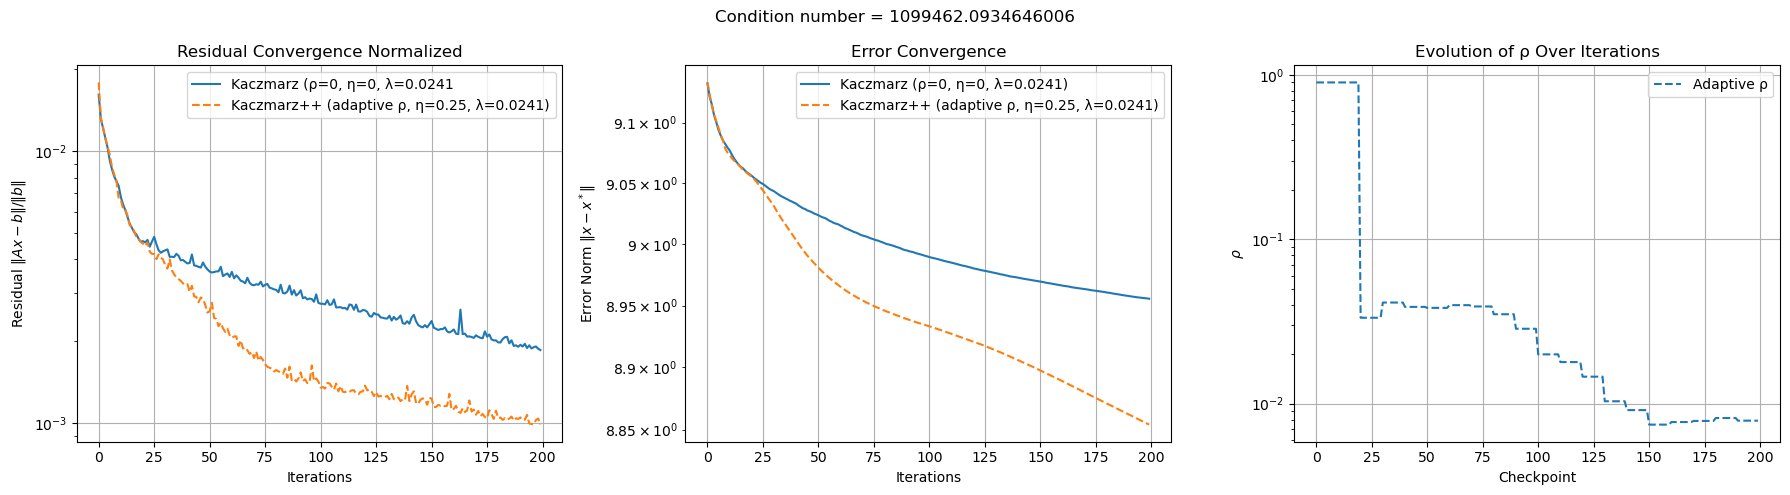

In [248]:
np.random.seed(42)

cond_values = np.array([0,1, 2, 3])

m = 1000
n = 100

k_values = []

#block size, lambda
#s = optimal_s_lambda(A, 1, k)[0].astype(int)

for cond in cond_values:
    A, b, x_true, x_star = generate_rand_system(m, n, cond=cond, noise_std = 0)
    condition = np.linalg.cond(A)
    k = k_singular_values(A = A)
    k_values.append(k)
    #s = optimal_s_lambda(A, 1, k)[0].astype(int)
    s = 50
    print(f"block size: {s}")
    lamb = optimal_s_lambda(A, 1, k)[1]
    #lamb = 0.001
    #lamb = calculate_lamda_mu_nu(A.T @ A, s)[0]
    eta = s/(2*n)
    #eta = 0.1
    lookback = 10 
    #no adaptive acceleration
    x_kacz_reg, residuals_reg, residual_norms_reg, update_norms_reg, errors_reg, rhos_reg = kaczmarz(A, b, lamb = lamb, accelerated =False, eta = 0, rho = 0, n_steps = 200, block_size = s, p = lookback, x_true = x_true)
    #adaptive acceleration
    x_kacz_aa, residuals_reg_aa, residual_norms_aa, update_norms_reg_aa, errors_reg_aa, rhos_aa = kaczmarz(A, b, lamb = lamb, accelerated = True, eta = eta, rho = 0.9, n_steps = 200, block_size = s, p = lookback, x_true = x_true)

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"Condition number = {condition}")

    # Residual
    axs[0].plot(residual_norms_reg, label=f"Kaczmarz (ρ=0, η=0, λ={lamb:.3g}")
    axs[0].plot(residual_norms_aa, label=f"Kaczmarz++ (adaptive ρ, η={eta:.3g}, λ={lamb:.3g})", linestyle='--')
    axs[0].set_yscale("log")
    axs[0].set_title("Residual Convergence Normalized")
    axs[0].set_xlabel("Iterations")
    axs[0].set_ylabel(r"Residual $\|Ax - b\| / \|b\|$")
    axs[0].legend()
    axs[0].grid(True)
    
    # Error
    axs[1].plot(errors_reg, label=f"Kaczmarz (ρ=0, η=0, λ={lamb:.3g})")
    axs[1].plot(errors_reg_aa, label=f"Kaczmarz++ (adaptive ρ, η={eta:.3g}, λ={lamb:.3g})", linestyle='--')
    axs[1].set_yscale("log")
    axs[1].set_title("Error Convergence")
    axs[1].set_xlabel("Iterations")
    axs[1].set_ylabel(r"Error Norm $\|x - x^*\|$")
    axs[1].legend()
    axs[1].grid(True)
    
    # Adaptive ρ
    axs[2].plot(rhos_aa, label="Adaptive ρ", linestyle='--')
    axs[2].set_yscale("log")
    axs[2].set_title("Evolution of ρ Over Iterations")
    axs[2].set_xlabel("Checkpoint")
    axs[2].set_ylabel(r"$\rho$")
    axs[2].legend()
    axs[2].grid(True)
    
    plt.tight_layout()
    plt.show()

In [220]:
np.random.seed(42)
C = generate_rand_system(1000,100,0)[0]

/tmp/ipykernel_7432/4066594780.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x_star = np.linalg.lstsq(A,b)[0] #even though b = Ax, block Kaczmarz projects onto minimum norm solution of Ax = b, i.e. x_star.


In [221]:
np.linalg.cond(C)

1.8826282144577735

In [222]:
k_singular_values(C)

17

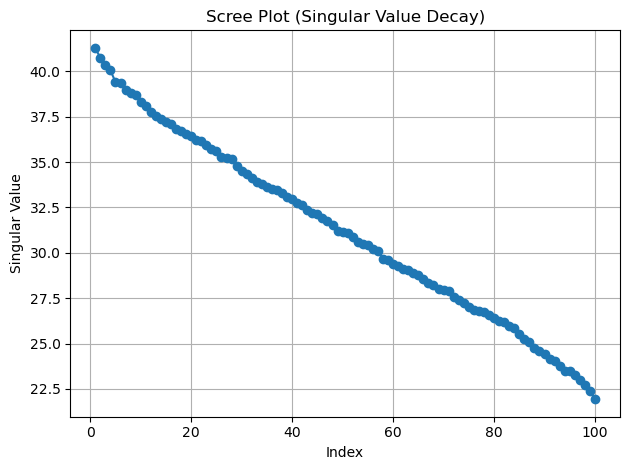

In [223]:

u,s,vt = np.linalg.svd(C)
plt.plot(np.arange(1, 100+1), s, marker='o')
plt.title("Scree Plot (Singular Value Decay)")
plt.xlabel("Index")
plt.ylabel("Singular Value")
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
def calculate_lamda_mu_nu(A, k):
    """
    Estimate lambda, mu, and nu from A^T A.
    k is block size
    """
    s2 = np.linalg.eigvalsh(A)
    s2[s2 < np.mean(s2) * 1e-8] = 0

    def f(lamda):
        return np.sum(s2 / (s2 + lamda)) - k

    lamda = root_scalar(f, bracket=[1e-8, np.max(s2) * len(s2) * 1e8]).root
    s2_min = np.min(s2[s2 > 0])
    mu = s2_min / (s2_min + lamda)
    num = np.sum((s2 > 0) / (s2 + lamda))
    denom = np.sum(s2 / (s2 + lamda)**2)
    lamda_prime = lamda * num / denom
    nu = 1 + lamda_prime / (s2_min + lamda)

    return lamda, mu, nu

In [80]:
def kaczmarz_plusplus_adaptive(A, b, x0, t_max, block_size=50, accelerated=True, reg= 0.001, seed=42, x_star = None):
    m, n = A.shape
    rng = np.random.default_rng(seed)

    if accelerated:
        lamda, mu, nu = calculate_lamda_mu_nu(A.T @ A, block_size)
        eta = 1 / nu
        z_param = 1.0
    else:
        lamda = reg
        eta = 0.0
        z_param = 0.0

    # Initialize
    X = np.zeros((1 + t_max, n))
    x = X[0, :] = x0.copy()
    #z = np.zeros(n)
    z = 0

    skip = round(n / block_size + 1)
    cnt = 1.0
    ratio = 0.0
    dist_old = dist_new = 0.0

    # Tracking variables
    b_norm = np.linalg.norm(b)
    residuals = []
    residual_norms = []
    errors = [] if x_star is not None else None
    error_norms = [] if x_star is not None else None
    rhos = []

    for t in range(1, t_max + 1):
        # Uniformly sample a block of rows
        indices = rng.choice(m, size=block_size, replace=False)
        A_block = A[indices, :]
        b_block = b[indices]
        b_block = b_block.flatten()

        # Solve sketched system
        b_ = A_block @ x - b_block
        cho = scipy.linalg.cho_factor(A_block @ A_block.T + lamda * np.eye(block_size))
        w = A_block.T @ scipy.linalg.cho_solve(cho, (A_block @ x - b_block)) 
        
        # G = A_block @ A_block.T + lamda * np.eye(block_size)
        # L = scipy.linalg.cholesky(G, lower=True)
        # b_ = A_block @ x - b_block
        # u_ = scipy.linalg.solve_triangular(L, b_, lower=True)
        # u = scipy.linalg.solve_triangular(L.T, u_, lower=False)
        # w = A_block.T @ u

        # Update
        z = z_param * (z - w)
        x = x - w + eta * z
        X[t, :] = x.copy()

         # Full residual
        r = A @ x - b
        residuals.append(np.linalg.norm(r))
        residual_norms.append(np.linalg.norm(r)/b_norm)

        # Error to ground truth
        if x_star is not None:
            err = x - x_star
            #errors.append(err.copy())
            error_norms.append(np.linalg.norm(err))

        # Track residual norms for adaptive rho
        if t % (2 * skip) <= skip:
            dist_old += np.linalg.norm(r)**2
        else:
            dist_new += np.linalg.norm(r)**2

        # Adaptive rho and eta update
        # if accelerated and t % (2 * skip) == 0:
        #     a_old = cnt ** np.log(cnt)
        #     a_new = (cnt + 1) ** np.log(cnt + 1)
        #     ratio = ratio * (a_old / a_new) + min(1, dist_new / dist_old) * (1 - a_old / a_new)
        #     rho = max(0, 1 - ratio ** (1 / skip))
        #     z_param = (1 - rho) / (1 + rho)
        #     eta = 1 / nu  # or: max(0, (1 / nu - rho) / (1 - rho))
        #     cnt += 1
        #     dist_old = dist_new = 0.0
        if accelerated and t % (2 * skip) == 0:
            a_old = cnt ** np.log(cnt)
            a_new = (cnt + 1) ** np.log(cnt + 1)
            ratio = ratio * (a_old / a_new) + dist_new / dist_old * (1 - a_old / a_new)
            rho = 1 - ratio ** (1 / skip)
            z_param = (1 - rho) / (1 + rho)
            eta = 1 / nu  # or: max(0, (1 / nu - rho) / (1 - rho))
            cnt += 1
            dist_old = dist_new = 0.0
            
        rho = (1 - z_param) / (1 + z_param)  # infer rho from z_param
        rhos.append(rho)

    return X, residual_norms, error_norms, rhos, lamda, eta

In [81]:
A, b, x_true, x_star = generate_rand_system(1000, 100, 0, noise_std = 0)

/tmp/ipykernel_13973/4066594780.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x_star = np.linalg.lstsq(A,b)[0] #even though b = Ax, block Kaczmarz projects onto minimum norm solution of Ax = b, i.e. x_star.


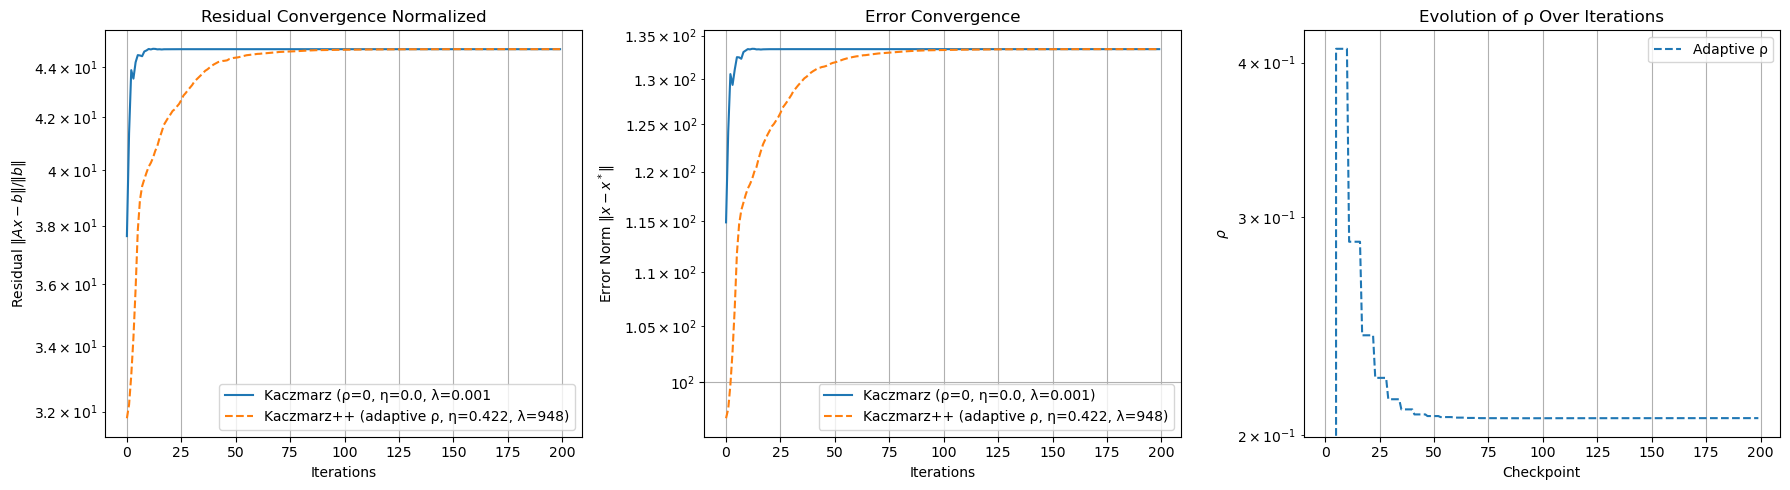

In [82]:
X, residual_norms_aa, error_norms_aa, rhos_aa, lamb_aa, eta_aa = kaczmarz_plusplus_adaptive(A, b, np.zeros(100), 200, block_size=50, accelerated=True, reg= 0.001, seed=42, x_star = x_star)
X, residual_norms_reg, error_norms_reg, rhos_reg, lamb_reg, eta_reg = kaczmarz_plusplus_adaptive(A, b, np.zeros(100), 200, block_size=50, accelerated=False, reg= 0.001, seed=42, x_star = x_star)

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
#fig.suptitle(f"Condition number = {condition}")

# Residual
axs[0].plot(residual_norms_reg, label=f"Kaczmarz (ρ=0, η={eta_reg}, λ={lamb_reg:.3g}")
axs[0].plot(residual_norms_aa, label=f"Kaczmarz++ (adaptive ρ, η={eta_aa:.3g}, λ={lamb_aa:.3g})", linestyle='--')
axs[0].set_yscale("log")
axs[0].set_title("Residual Convergence Normalized")
axs[0].set_xlabel("Iterations")
axs[0].set_ylabel(r"Residual $\|Ax - b\| / \|b\|$")
axs[0].legend()
axs[0].grid(True)

# Error
axs[1].plot(error_norms_reg, label=f"Kaczmarz (ρ=0, η={eta_reg}, λ={lamb_reg:.3g})")
axs[1].plot(error_norms_aa, label=f"Kaczmarz++ (adaptive ρ, η={eta_aa:.3g}, λ={lamb_aa:.3g})", linestyle='--')
axs[1].set_yscale("log")
axs[1].set_title("Error Convergence")
axs[1].set_xlabel("Iterations")
axs[1].set_ylabel(r"Error Norm $\|x - x^*\|$")
axs[1].legend()
axs[1].grid(True)

# Adaptive ρ
axs[2].plot(rhos_aa, label="Adaptive ρ", linestyle='--')
axs[2].set_yscale("log")
axs[2].set_title("Evolution of ρ Over Iterations")
axs[2].set_xlabel("Checkpoint")
axs[2].set_ylabel(r"$\rho$")
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()